# **Sistem rekomendasi**
Nama: Joko Prabowo <br>
Username: jprabowo <br>
email: jokoprabowwo4550@gmail.com


In [86]:
import textwrap
import uuid
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## **Data Loading**
---
Proses dalam menyimpan dan memuat data untuk diproses lebih lanjut

In [48]:
url = 'https://github.com/jokoprabowo/mobile_game_recommender_system/releases/download/dataset/android-games.csv'
df = pd.read_csv(url)
df.head()

,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
0,1,Garena Free Fire- World Series,86273129,500.0 M,4,2.1,6.9,0.0,GAME ACTION,63546766,4949507,3158756,2122183,12495915,False
1,2,PUBG MOBILE - Traverse,37276732,500.0 M,4,1.8,3.6,0.0,GAME ACTION,28339753,2164478,1253185,809821,4709492,False
2,3,Mobile Legends: Bang Bang,26663595,100.0 M,4,1.5,3.2,0.0,GAME ACTION,18777988,1812094,1050600,713912,4308998,False
3,4,Brawl Stars,17971552,100.0 M,4,1.4,4.4,0.0,GAME ACTION,13018610,1552950,774012,406184,2219794,False
4,5,Sniper 3D: Fun Free Online FPS Shooting Game,14464235,500.0 M,4,0.8,1.5,0.0,GAME ACTION,9827328,2124154,1047741,380670,1084340,False


In [49]:
row, col = df.shape
print(f'Jumlah baris: {row}')
print(f'Jumlah kolom: {col}')

Jumlah baris: 1730
Jumlah kolom: 15


Dengan begitu dalam dataset ini terdapat total 1730 baris dengan 15 kolom

## **Exploratory Data Analysis**
---
 Proses untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data.

### Deskripsi Variabel
---
Proses untuk mendeskripsikan setiap variabel agar variabel tersebut dapat dimengerti secara umum

Berdasarkan informasi dari kaggle, variable-variable diatas dapat diartikan:

Variabel|Keterangan
---|---
rank|peringkat dalam kategori tertentu
title|judul game
total rating|jumlah total penilaian
installs|perkiraan tonggak instalasi
average rating|penilaian rata-rata dari bintang 5
growth (30 days)|pertumbuhan persen dalam 30 hari
growth (60 days)|pertumbuhan persen dalam 60 hari
price|harga dalam dolar
category|kategori permainan
5 star ratings|jumlah penilaian bintang 5
4 star ratings|jumlah penilaian bintang 4
3 star ratings|jumlah penilaian bintang 3
2 star ratings|jumlah penilaian bintang 2
1 star ratings|jumlah penilaian bintang 1
paid|permainan berbayar atau tidak

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1730 entries, 0 to 1729
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rank              1730 non-null   int64  
 1   title             1730 non-null   object 
 2   total ratings     1730 non-null   int64  
 3   installs          1730 non-null   object 
 4   average rating    1730 non-null   int64  
 5   growth (30 days)  1730 non-null   float64
 6   growth (60 days)  1730 non-null   float64
 7   price             1730 non-null   float64
 8   category          1730 non-null   object 
 9   5 star ratings    1730 non-null   int64  
 10  4 star ratings    1730 non-null   int64  
 11  3 star ratings    1730 non-null   int64  
 12  2 star ratings    1730 non-null   int64  
 13  1 star ratings    1730 non-null   int64  
 14  paid              1730 non-null   bool   
dtypes: bool(1), float64(3), int64(8), object(3)
memory usage: 191.0+ KB


Berdasarkan data diatas dapat terlihat bahwa:
*   Terdapat 4 kolom kategorik dengan tipe data object dan bool, yaitu `title`, `installs`, `category`, dan `paid`
*   Terdapat 11 kolom numerik dengan tipe data int64, daan float64, yaitu `rank`, `total ratings`, `average rating`, `growth (30 days)`, `growth (60 days)`, `price`, `5 star ratings`, `4 star ratings`, `3 star ratings`, `2 star ratings`, dan `1 star ratings`



In [51]:
df.describe()

,rank,total ratings,average rating,growth (30 days),growth (60 days),price,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings
count,1730.000000,1.730000e+03,1730.000000,1730.000000,1730.000000,1730.000000,1.730000e+03,1.730000e+03,1.730000e+03,1.730000e+03,1.730000e+03
mean,50.386705,1.064332e+06,3.908092,321.735896,122.554971,0.010942,7.622315e+05,1.164366e+05,5.706307e+04,2.710336e+04,1.014950e+05
std,28.936742,3.429250e+06,0.290973,6018.914507,2253.891703,0.214987,2.538658e+06,3.021631e+05,1.495314e+05,8.154542e+04,4.083745e+05
min,1.000000,3.299300e+04,2.000000,0.000000,0.000000,0.000000,1.397500e+04,2.451000e+03,7.180000e+02,2.660000e+02,5.450000e+02
25%,25.000000,1.759992e+05,4.000000,0.100000,0.200000,0.000000,1.277300e+05,2.064300e+04,9.652500e+03,4.262250e+03,1.281200e+04
50%,50.000000,4.286065e+05,4.000000,0.500000,1.000000,0.000000,2.964340e+05,5.098050e+04,2.507800e+04,1.067550e+04,3.368600e+04
75%,75.000000,8.837970e+05,4.000000,1.700000,3.300000,0.000000,6.198358e+05,1.018140e+05,5.229500e+04,2.322875e+04,8.015725e+04
max,100.000000,8.627313e+07,4.000000,227105.700000,69441.400000,7.490000,6.354677e+07,5.404966e+06,3.158756e+06,2.122183e+06,1.249592e+07


Tabel diatas memperlihatkan informasi statistik pada setiap kolom yaitu:

Variabel|Keterangan
---|---
count|jumlah sampel
mean|nilai rata-rata
std|standar deviasi
min|nilai minimum
25%|kuartil pertama
50%|kuartil kedua
75%|kuartil ketiga
max|nilai maximum


### Unvariate Analysis
---
Proses untuk menganalisis data terhadap satu variabel secara mandiri

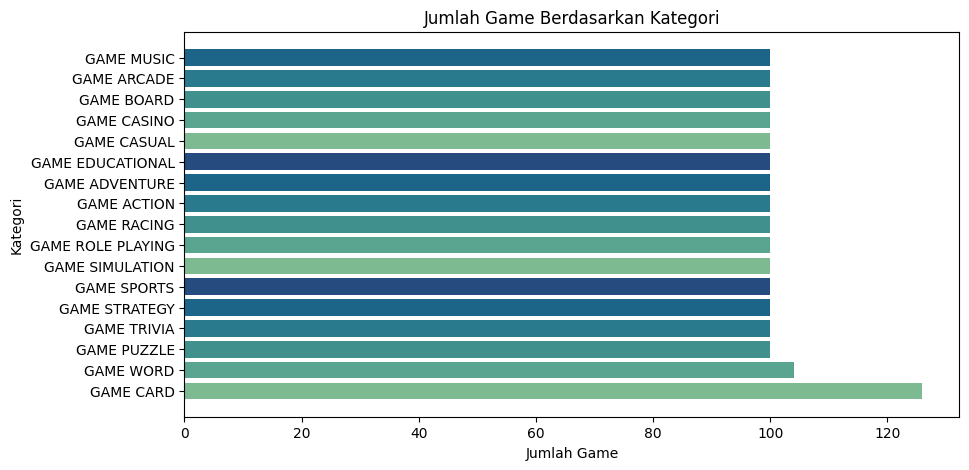

In [52]:
plt.figure(figsize=(10, 5))
color = sns.color_palette('crest')
plt.barh(df['category'].value_counts().index, df['category'].value_counts(), color=color)
plt.title('Jumlah Game Berdasarkan Kategori')
plt.xlabel('Jumlah Game')
plt.ylabel('Kategori')
plt.show()

Berdasarkan data visual diatas, dari sekian banyaknya kategori game "Game Card" atau permainan kartu merupakan kategori yang memiliki total jumlah game terbanyak

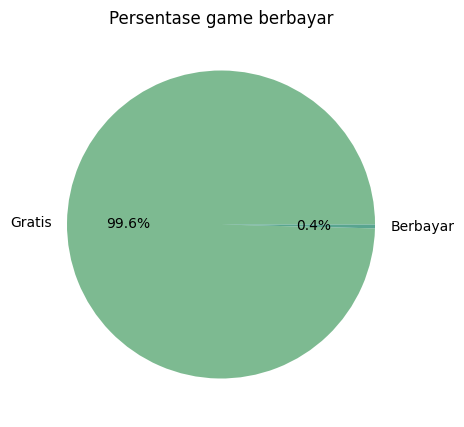

In [53]:
status = df['paid'].value_counts()
status.index = ['Gratis', 'Berbayar']

plt.figure(figsize=(10, 5))
colors = sns.color_palette('crest')
plt.pie(status, labels=status.index, autopct='%1.1f%%', colors=colors)
plt.title('Persentase game berbayar')
plt.show()

Berdasarkan pie chart diatas terlihat bahwa mayoritas game yang terdapat dalam dataset ini merupakan game gratis dengan persentase mencapai 99.6%

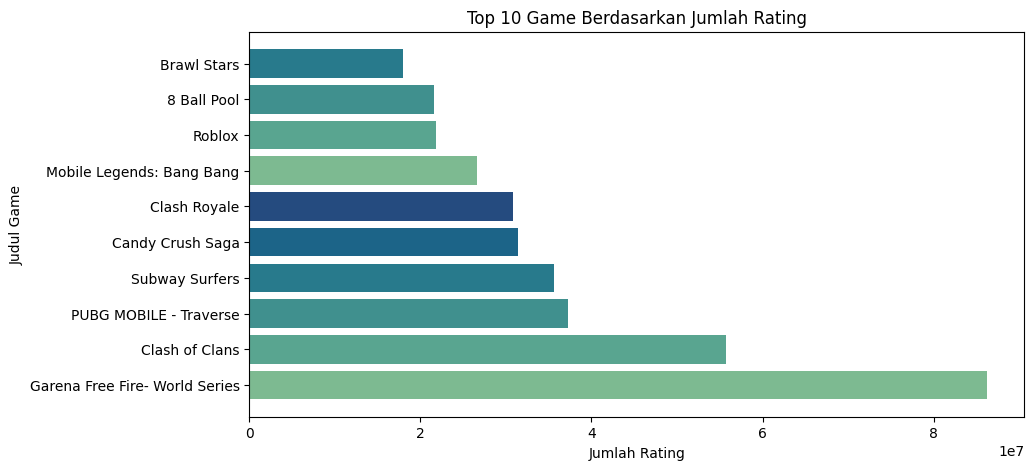

In [54]:
top10_game = df.sort_values(by='total ratings', ascending=False).head(10)
top10_game = top10_game[['title', 'total ratings']]
top10_game

plt.figure(figsize=(10, 5))
color = sns.color_palette('crest')
plt.barh(top10_game['title'], top10_game['total ratings'], color=color)
plt.title('Top 10 Game Berdasarkan Jumlah Rating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Game')
plt.show()

Data visualisasi diatas menunjukan 10 game dengan total rating terbanyak, dimana game Garena Free Fire - World Series menempati urutan pertama dengan lebih dari 8e7 rating atau lebih dari 80.000.000 total rating

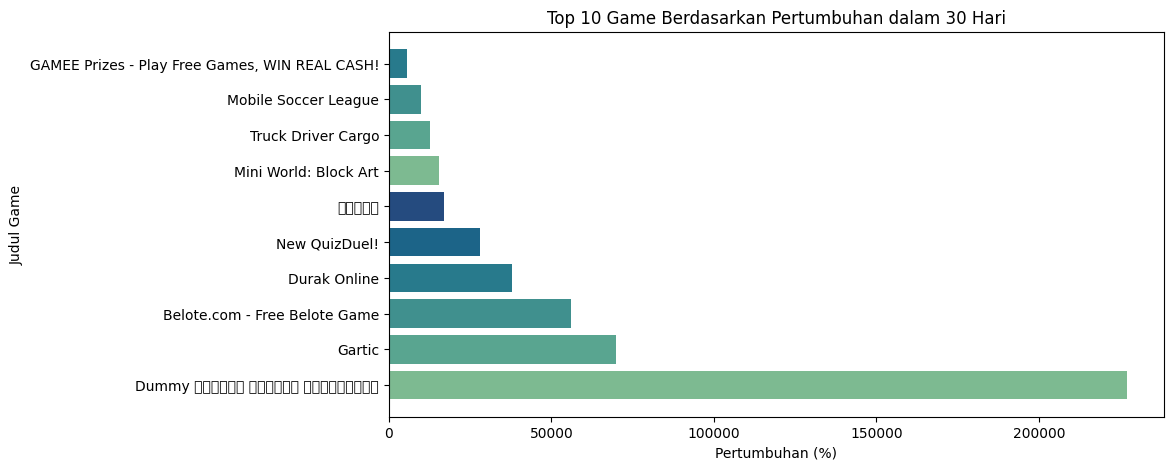

In [55]:
top10_30days = df.sort_values(by='growth (30 days)', ascending=False).head(10)
top10_30days = top10_30days[['title', 'growth (30 days)']]

plt.figure(figsize=(10, 5))
color = sns.color_palette('crest')
plt.barh(top10_30days['title'], top10_30days['growth (30 days)'], color=color)
plt.title('Top 10 Game Berdasarkan Pertumbuhan dalam 30 Hari')
plt.xlabel('Pertumbuhan (%)')
plt.ylabel('Judul Game')
plt.show()

Data visualisasi diatas menunjukan top 10 game dengan tingkat pertumbuhan tertinggi dalam 30 hari.

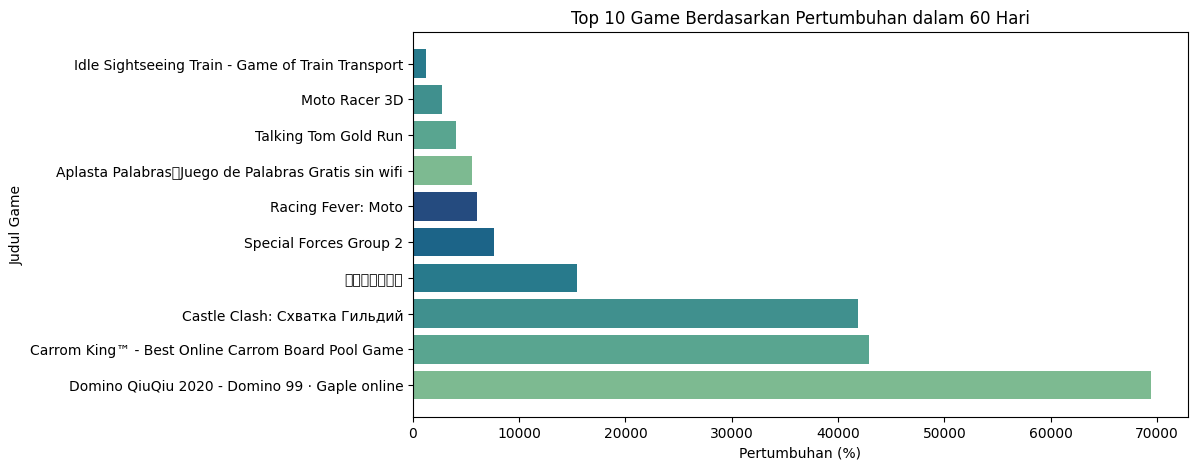

In [56]:
top10_60days = df.sort_values(by='growth (60 days)', ascending=False).head(10)
top10_60days = top10_60days[['title', 'growth (60 days)']]

plt.figure(figsize=(10, 5))
color = sns.color_palette('crest')
plt.barh(top10_60days['title'], top10_60days['growth (60 days)'], color=color)
plt.title('Top 10 Game Berdasarkan Pertumbuhan dalam 60 Hari')
plt.xlabel('Pertumbuhan (%)')
plt.ylabel('Judul Game')
plt.show()

Data visualisasi diatas menunjukan top 10 game dengan tingkat pertumbuhan tertinggi dalam 60 hari.

### Multivariate analysis
---
Proses yang digunakan untuk menganalisis hubungan antara dua variabel atau lebih

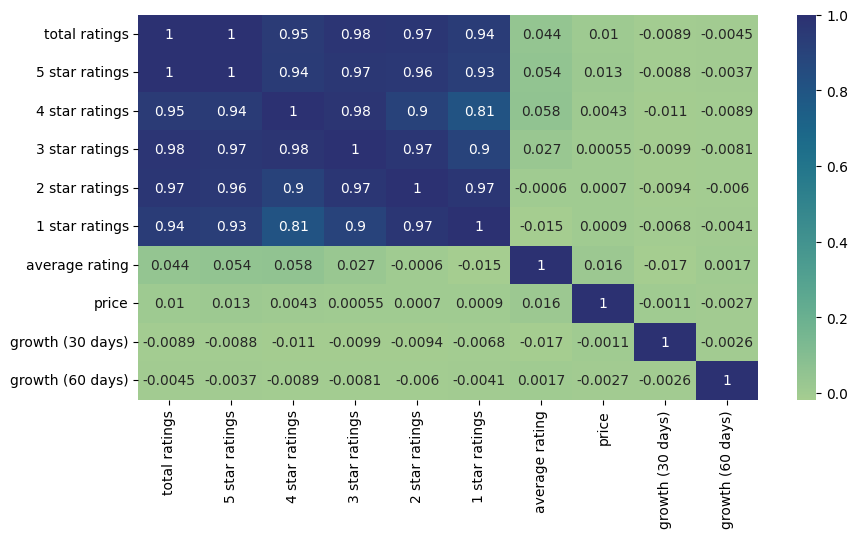

In [57]:
numerical = df[['total ratings', '5 star ratings', '4 star ratings', '3 star ratings', '2 star ratings', '1 star ratings', 'average rating', 'price', 'growth (30 days)', 'growth (60 days)']]
plt.figure(figsize=(10, 5))
sns.heatmap(numerical.corr(), annot=True, cmap='crest')
plt.show()

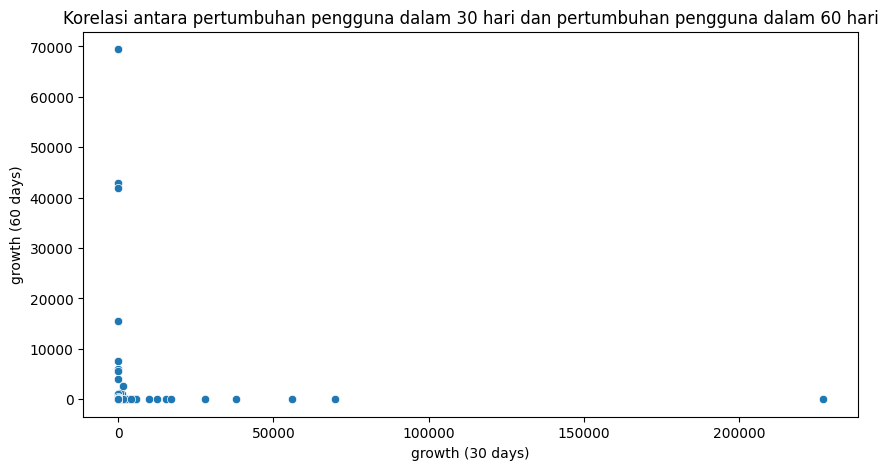

In [58]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='growth (30 days)', y='growth (60 days)', palette='crest')
plt.title('Korelasi antara pertumbuhan pengguna dalam 30 hari dan pertumbuhan pengguna dalam 60 hari')
plt.show()

Berdasarkan nilai korelasi yang didapatkan melalui heatmap (-0.0026) dan data visual diatas disimpulkan bahwa fitur growth (30 days) dan growth (60 days) memiliki hubungan yang lemah

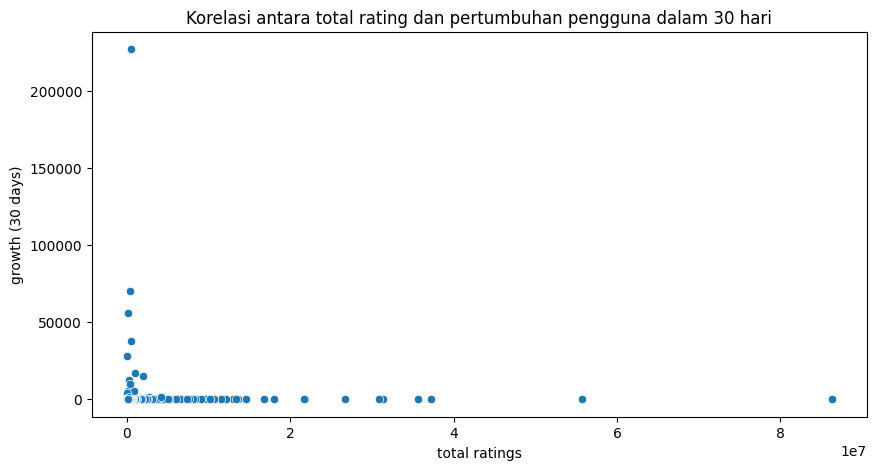

In [59]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='total ratings', y='growth (30 days)', palette='crest')
plt.title('Korelasi antara total rating dan pertumbuhan pengguna dalam 30 hari')
plt.show()

Berdasarkan nilai korelasi yang didapatkan melalui heatmap (-0.0089) dan data visual diatas disimpulkan bahwa fitur total rating dan growth (30 days) memiliki hubungan yang lemah

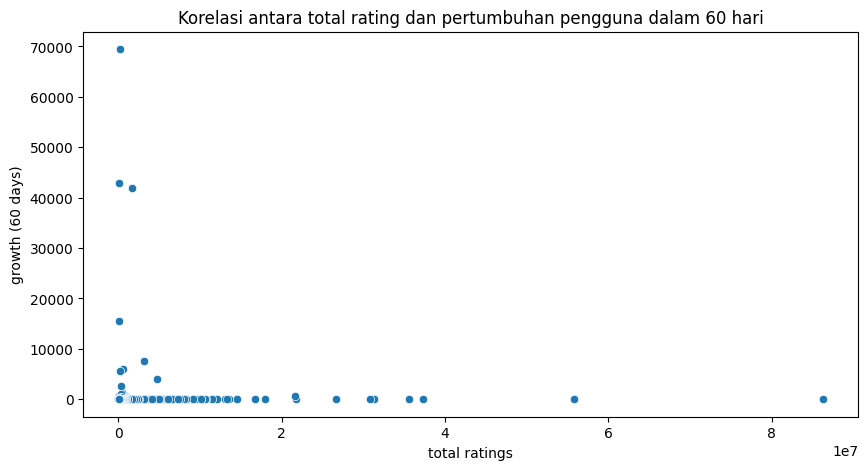

In [60]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='total ratings', y='growth (60 days)', palette='crest')
plt.title('Korelasi antara total rating dan pertumbuhan pengguna dalam 60 hari')
plt.show()

Berdasarkan nilai korelasi yang didapatkan melalui heatmap (-0.0045) dan data visual diatas disimpulkan bahwa fitur total rating dan growth (60 days) memiliki hubungan yang lemah

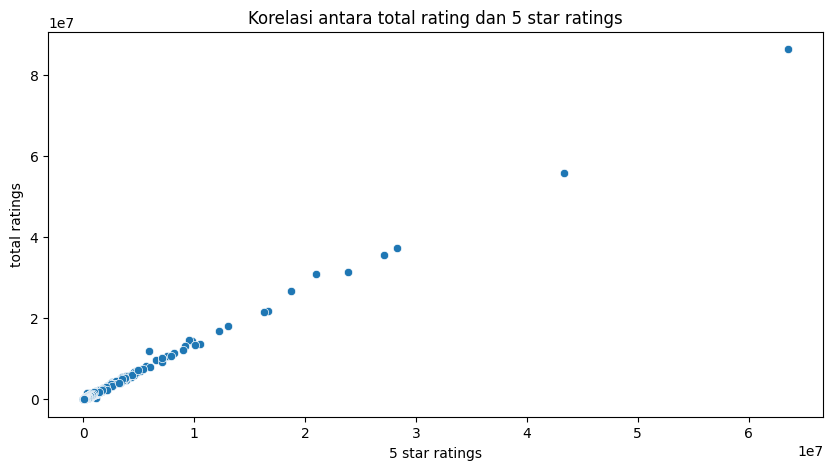

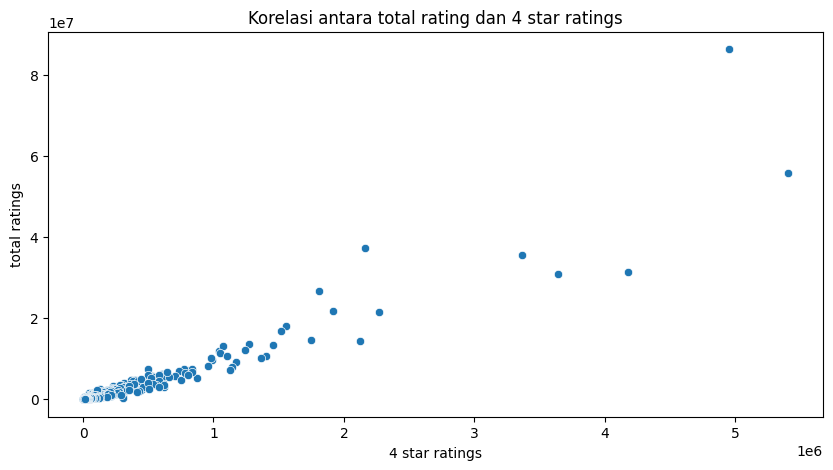

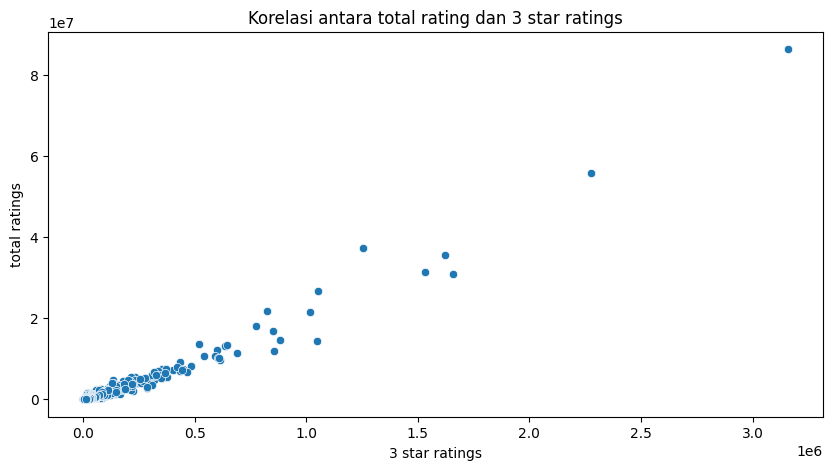

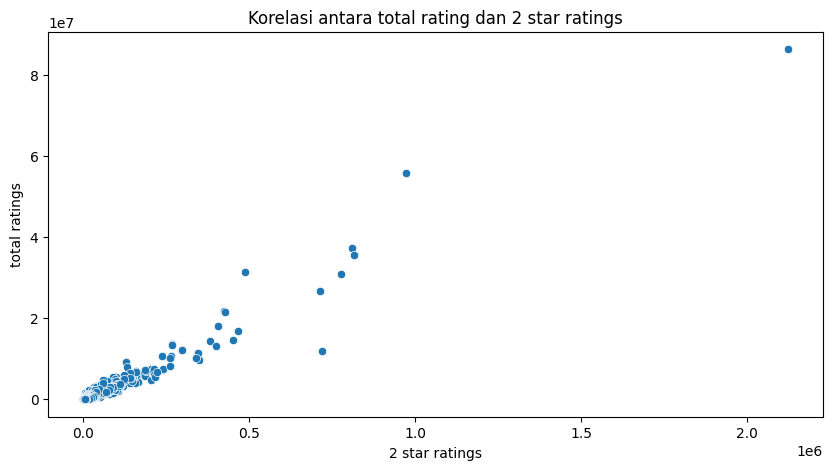

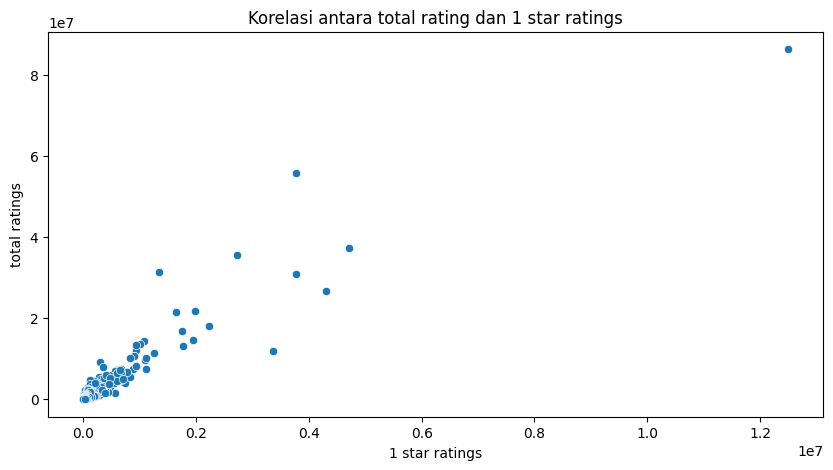

In [61]:
ratings = df[['5 star ratings', '4 star ratings', '3 star ratings', '2 star ratings', '1 star ratings']]
for col in ratings.columns:
  plt.figure(figsize=(10, 5))
  sns.scatterplot(data=df, x=col, y='total ratings', palette='crest')
  plt.title(f'Korelasi antara total rating dan {col}')
  plt.show()

Namun berdasarkan data visual diatas total rating memiliki hubungan yang kuat dengan 5 star ratings, 4 star ratings, 3 star ratings, 2 star ratings, dan 1 star ratings. Hal ini dibuktikan melalui skor korelasi yang diperoleh dari heatmap secara berurutan yaitu 1, 0.95, 0.98, 0.97, dan 0.94.

## **Data preparation**
---
Proses untuk menyiapkan data mentah agar dapat diproses dan dianalisis lebih lanjut.

### Menangani missing value
---
Proses untuk menghapus kolom yang bernilai kosong (NaN) serta terduplikat, untuk mengatasi data ganda dan data yang tidak lengkap

In [62]:
# menampilkan data kosong
df.isnull().sum()

,0
rank,0
title,0
total ratings,0
installs,0
average rating,0
growth (30 days),0
growth (60 days),0
price,0
category,0
5 star ratings,0


Berdasarkan data diatas, tidak ditemukan data kosong dalam dataset ini.

Kemudian mari melakukan cek terhadap data terduplikasi dalam kasus data ini cek judul game yang terduplikasi

In [63]:
# menampilkan data terduplikasi
print(len(df[df.duplicated(subset='title')]))

55


Berdasarkan data diatas terdapat 55 data dengan judul game yang sama yang harus dihapus

In [64]:
# menghapus data terduplikasi
df.drop_duplicates(subset='title', inplace=True)
df.shape

(1675, 15)

Sesudah menghapus data duplikat dataset game memiliki total 1675 baris dari yang sebelumnya 1730 baris

### Menambahkan data penting
---
Proses untuk menambahkan dataa yang kurang untuk melakukan proses selanjutnya

Dalam data yang diperoleh dari kaggle ini belum ada dataset untuk review  yang sebenarnya diperlukan dalam proses collaborative filtering oleh karenanya data tersebut akan dibuat terlebih dahulu

Namun sebelum itu ada hal yang perlu ditambahkan dalam dataset game agar dapat membuat contoh dataset review yaitu game id

In [65]:
df.insert(0, 'gameId', '')
df['gameId'] = df.apply(lambda x: uuid.uuid4(), axis=1)
df.head()

,gameId,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
0,580891a3-3771-43e8-a590-dfa5841f64af,1,Garena Free Fire- World Series,86273129,500.0 M,4,2.1,6.9,0.0,GAME ACTION,63546766,4949507,3158756,2122183,12495915,False
1,8456d8c3-000f-4371-96aa-88441b918c54,2,PUBG MOBILE - Traverse,37276732,500.0 M,4,1.8,3.6,0.0,GAME ACTION,28339753,2164478,1253185,809821,4709492,False
2,d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf,3,Mobile Legends: Bang Bang,26663595,100.0 M,4,1.5,3.2,0.0,GAME ACTION,18777988,1812094,1050600,713912,4308998,False
3,54feaa8e-d9c8-4795-bc9e-323754e4e120,4,Brawl Stars,17971552,100.0 M,4,1.4,4.4,0.0,GAME ACTION,13018610,1552950,774012,406184,2219794,False
4,fffca0c4-3528-4368-ac99-dd2925ce212b,5,Sniper 3D: Fun Free Online FPS Shooting Game,14464235,500.0 M,4,0.8,1.5,0.0,GAME ACTION,9827328,2124154,1047741,380670,1084340,False


Membuat dataframe review

In [66]:
reviews = pd.DataFrame(columns=['userId', 'gameId', 'rating'])
reviews.head()

,userId,gameId,rating


In [67]:
# mengisi dataframe

# membuat user id
userId = [uuid.uuid4() for x in range(200)]
# menyimpan game id ke dalam list
gameId = df['gameId'].unique().tolist()

for x in range(len(gameId)):
  reviews.loc[len(reviews.index)] = [random.choice(userId), gameId[x], random.randint(1, 5)]

In [68]:
reviews.head()

,userId,gameId,rating
0,da61fe92-a591-4687-9366-232185264f8d,580891a3-3771-43e8-a590-dfa5841f64af,1
1,0f4f8839-c80f-474b-9568-c3fc1c20fab3,8456d8c3-000f-4371-96aa-88441b918c54,2
2,2d219fc6-e7b5-4a35-b3a6-6b4802fa3d33,d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf,1
3,98719602-e05e-4385-a7cb-ea6c1541ac42,54feaa8e-d9c8-4795-bc9e-323754e4e120,5
4,7fd0867b-b5a6-4ec5-86c7-f5b667ab2cc8,fffca0c4-3528-4368-ac99-dd2925ce212b,3


Tabel diatas menandakan bahwa dataset review telah berhasil dibuat

### Normalisasi data
---
Proses untuk melakukan penyederhanaan kategori agar kategori yang ada dalam dataset ini hanya terdiri dari 1 kata

In [69]:
df['category'] = df['category'].str.lower()
df['category'] = df['category'].str.split(' ', n=1).str.get(-1)
df['category'].unique()

array(['action', 'adventure', 'arcade', 'board', 'card', 'casino',
       'casual', 'educational', 'music', 'puzzle', 'racing',
       'role playing', 'simulation', 'sports', 'strategy', 'trivia',
       'word'], dtype=object)

In [70]:
df.head()

,gameId,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
0,580891a3-3771-43e8-a590-dfa5841f64af,1,Garena Free Fire- World Series,86273129,500.0 M,4,2.1,6.9,0.0,action,63546766,4949507,3158756,2122183,12495915,False
1,8456d8c3-000f-4371-96aa-88441b918c54,2,PUBG MOBILE - Traverse,37276732,500.0 M,4,1.8,3.6,0.0,action,28339753,2164478,1253185,809821,4709492,False
2,d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf,3,Mobile Legends: Bang Bang,26663595,100.0 M,4,1.5,3.2,0.0,action,18777988,1812094,1050600,713912,4308998,False
3,54feaa8e-d9c8-4795-bc9e-323754e4e120,4,Brawl Stars,17971552,100.0 M,4,1.4,4.4,0.0,action,13018610,1552950,774012,406184,2219794,False
4,fffca0c4-3528-4368-ac99-dd2925ce212b,5,Sniper 3D: Fun Free Online FPS Shooting Game,14464235,500.0 M,4,0.8,1.5,0.0,action,9827328,2124154,1047741,380670,1084340,False


### TF-IDF vectorizer
---
Proses untuk menemukan representasi fitur penting untuk setiap kategori game

In [71]:
tf = TfidfVectorizer()
tf.fit(df['category'])
tf.get_feature_names_out()

array(['action', 'adventure', 'arcade', 'board', 'card', 'casino',
       'casual', 'educational', 'music', 'playing', 'puzzle', 'racing',
       'role', 'simulation', 'sports', 'strategy', 'trivia', 'word'],
      dtype=object)

Kemudian transformasikan kedalam bentuk matrix

In [72]:
tfidf_matrix = tf.fit_transform(df['category'])

tfidf_matrix.shape

(1675, 18)

In [73]:
tfidf_matrix.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [74]:
tfidf_matrix = tf.fit_transform(df['category'])

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=df.title
).sample(10, axis=1, replace=True).sample(5, axis=0)

,racing,puzzle,casino,music,arcade,trivia,casino,music,trivia,casino
title,,,,,,,,,,
AVATAR MUSIK - Music and Dance Game,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Lost in Harmony,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Mr Bullet - Spy Puzzles,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
My Candy Love - Episode / Otome game,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sudoku,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Data diatas merupakan contoh dari matriks tf-idf terhadap 5 contoh game yang ada

### Encoding features
---
Proses untuk mengubah data kategorik menjadi numerik atau sebaliknya

Pada tahap ini, data yang akan digunakan perlu disiapkan sebelum dilakukannya proses encoding



In [75]:
user = reviews['userId'].unique().tolist()
print('List user', user[:10])

user_encoded = {x: i for i, x in enumerate(user)}
print('encoded user id : ', user_encoded)

user_decoded = {i: x for i, x in enumerate(user)}
print('decoded user id : ', user_decoded)

List user [UUID('da61fe92-a591-4687-9366-232185264f8d'), UUID('0f4f8839-c80f-474b-9568-c3fc1c20fab3'), UUID('2d219fc6-e7b5-4a35-b3a6-6b4802fa3d33'), UUID('98719602-e05e-4385-a7cb-ea6c1541ac42'), UUID('7fd0867b-b5a6-4ec5-86c7-f5b667ab2cc8'), UUID('5cde411f-b5c8-40d8-910d-02acbdb13cca'), UUID('b01d2f4d-e6b3-4b38-a2d2-991e3b6395a1'), UUID('e1057701-288c-4e73-a86e-4d055100735a'), UUID('0ee8e670-57ae-4810-8098-bd8ca2560566'), UUID('c57dc9b0-9d32-496d-ba50-20af48aff166')]
encoded user id :  {UUID('da61fe92-a591-4687-9366-232185264f8d'): 0, UUID('0f4f8839-c80f-474b-9568-c3fc1c20fab3'): 1, UUID('2d219fc6-e7b5-4a35-b3a6-6b4802fa3d33'): 2, UUID('98719602-e05e-4385-a7cb-ea6c1541ac42'): 3, UUID('7fd0867b-b5a6-4ec5-86c7-f5b667ab2cc8'): 4, UUID('5cde411f-b5c8-40d8-910d-02acbdb13cca'): 5, UUID('b01d2f4d-e6b3-4b38-a2d2-991e3b6395a1'): 6, UUID('e1057701-288c-4e73-a86e-4d055100735a'): 7, UUID('0ee8e670-57ae-4810-8098-bd8ca2560566'): 8, UUID('c57dc9b0-9d32-496d-ba50-20af48aff166'): 9, UUID('acb7349f-a846

In [76]:
game = reviews['gameId'].unique().tolist()
print('List game', game[:10])

game_encoded = {x: i for i, x in enumerate(game)}
print('encoded game id : ', game_encoded)

game_decoded = {i: x for i, x in enumerate(game)}
print('decoded game id : ', game_decoded)

List game [UUID('580891a3-3771-43e8-a590-dfa5841f64af'), UUID('8456d8c3-000f-4371-96aa-88441b918c54'), UUID('d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf'), UUID('54feaa8e-d9c8-4795-bc9e-323754e4e120'), UUID('fffca0c4-3528-4368-ac99-dd2925ce212b'), UUID('3b32e27e-fb16-409e-87eb-bef7eca855ae'), UUID('fb3a598f-5a58-49b7-9531-6e55059bfd05'), UUID('6a2b2288-5221-4f2c-8be0-5242a39eb7b4'), UUID('3f7fb8ff-1dff-4107-bbb8-5522364b2a81'), UUID('1844b067-2e1d-4f9f-b513-b1ea56a25c7a')]
encoded game id :  {UUID('580891a3-3771-43e8-a590-dfa5841f64af'): 0, UUID('8456d8c3-000f-4371-96aa-88441b918c54'): 1, UUID('d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf'): 2, UUID('54feaa8e-d9c8-4795-bc9e-323754e4e120'): 3, UUID('fffca0c4-3528-4368-ac99-dd2925ce212b'): 4, UUID('3b32e27e-fb16-409e-87eb-bef7eca855ae'): 5, UUID('fb3a598f-5a58-49b7-9531-6e55059bfd05'): 6, UUID('6a2b2288-5221-4f2c-8be0-5242a39eb7b4'): 7, UUID('3f7fb8ff-1dff-4107-bbb8-5522364b2a81'): 8, UUID('1844b067-2e1d-4f9f-b513-b1ea56a25c7a'): 9, UUID('872fd922-6fa5

Kemudian cek total dana dan lakukan normalisasi dengan mengubah tipe data rating ke dalam float

In [77]:
num_user = len(user_encoded)
print('Total user', num_user)

num_game = len(game_encoded)
print('Total game', num_game)

# Mengubah tipe data raating menjadi float
reviews['rating'] = reviews['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(reviews['rating'])

# Nilai maksimal rating
max_rating = max(reviews['rating'])

print('Number of Game: {}, Min Rating: {}, Max Rating: {}'.format(
    num_game, min_rating, max_rating
))

Total user 200
Total game 1675
Number of Game: 1675, Min Rating: 1.0, Max Rating: 5.0


Kemudian petakan setiap data tersebut kedalam dataframe

In [78]:
reviews['user'] = reviews['userId'].map(user_encoded)
reviews['game'] = reviews['gameId'].map(game_encoded)
reviews['rating'] = reviews['rating']
reviews.head()

,userId,gameId,rating,user,game
0,da61fe92-a591-4687-9366-232185264f8d,580891a3-3771-43e8-a590-dfa5841f64af,1.0,0,0
1,0f4f8839-c80f-474b-9568-c3fc1c20fab3,8456d8c3-000f-4371-96aa-88441b918c54,2.0,1,1
2,2d219fc6-e7b5-4a35-b3a6-6b4802fa3d33,d3f9c3e7-3f4f-48d2-9bd2-4ad58199eeaf,1.0,2,2
3,98719602-e05e-4385-a7cb-ea6c1541ac42,54feaa8e-d9c8-4795-bc9e-323754e4e120,5.0,3,3
4,7fd0867b-b5a6-4ec5-86c7-f5b667ab2cc8,fffca0c4-3528-4368-ac99-dd2925ce212b,3.0,4,4


### Train-test-split data
---
Proses untuk memisahkan dataset menjadi data latih dan data uji

Pada proyek ini, data latih dan data uji akan dibagi dengan rasio 80% dan 20%. Dimana sebelum memisah data, data perlu di acak terlebih dahulu

In [79]:
# mengacak data
collaborative = reviews.sample(frac=1, random_state=42)

# menyimpan kolom yang dibutuhkan kedalam variabel
x = reviews[['user', 'game']].values
y = collaborative['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# memisahkan data dengan rasio 80% untuk data latih dan 20% untuk data uji
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[   0    0]
 [   1    1]
 [   2    2]
 ...
 [ 153 1672]
 [ 144 1673]
 [ 167 1674]] [0.75 0.75 0.5  ... 1.   0.5  0.  ]


## **Model development**
---
Proses sistematis dalam membuat model untuk menyelesaikan masalah.

### Content based filtering
---
Metode yang digunakan data untuk memberikan rekomendasi berdasarkan karakteristik atau konten dari item yang ingin dianalisis atau direkomendasikan

#### Cosine similarity

Tahap ini dilakukan untuk mengukur derajat kesamaan antar game

In [80]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [81]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(5, axis=0)

Shape: (1675, 1675)


title,Tap Color - Color by number. Coloring Game,2 3 4 Player Mini Games,Bee Factory,Survivors: The Quest,LEGO® DUPLO® Town,Snake VS Block,Find The Differences - The Detective,Assassin's Creed Rebellion: Adventure RPG,Piano Fire - EDM Music & New Rhythm,Piano Game Classic - Challenge Music Song
title,,,,,,,,,,
How to Loot - Pin Pull & Hero Rescue,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
General Knowledge Quiz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Free RBX Master,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEAD TRIGGER 2 - Zombie Game FPS shooter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Monster Trucks Game for Kids 2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Tabel diatas merupakan matriks kesamaan terhadap beberapa game yang ada

Kemudian saatnya untuk membuat fungsi rekomendasi berdasarkan persiapan dari tahapan sebelumnya

In [82]:
def game_recommendations(title, similarity_data=cosine_sim_df, items=df[['title', 'category']], k=5):
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [83]:
df[df.title.eq('Brawl Stars')]

,gameId,rank,title,total ratings,installs,average rating,growth (30 days),growth (60 days),price,category,5 star ratings,4 star ratings,3 star ratings,2 star ratings,1 star ratings,paid
3,54feaa8e-d9c8-4795-bc9e-323754e4e120,4,Brawl Stars,17971552,100.0 M,4,1.4,4.4,0.0,action,13018610,1552950,774012,406184,2219794,False


In [84]:
game_recommendations('Brawl Stars')

,title,category
0,Garena Free Fire- World Series,action
1,FRAG Pro Shooter,action
2,Nebulous.io,action
3,Sea Battle 2,action
4,War Machines: Tank Battle - Army & Military Games,action


Tabel diatas merupakan daftar game yang direkomendasikan berdasarkan game `Brawl Stars` yang merupakan game dengan kategori `Action`

### Collaborative filtering
---
Metode dalam merekomendasikan suatu hal berdasarkkan preferensi pengguna

#### Process training

Membuat class menggunakan RecommenderNet untuk mempersiapkan proses

In [87]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_user, num_game, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_user = num_user
    self.num_game = num_game
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_user, 1)
    self.game_embedding = layers.Embedding(
        num_game,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.game_bias = layers.Embedding(num_game, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    game_vector = self.game_embedding(inputs[:, 1])
    game_bias = self.game_bias(inputs[:, 1])

    dot_user_game = tf.tensordot(user_vector, game_vector, 2)

    x = dot_user_game + user_bias + game_bias

    return tf.nn.sigmoid(x)

Lakukan proses compile terhadap model

In [88]:
model = RecommenderNet(num_user, num_game, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Kemudian mulai proses training

In [89]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6952 - root_mean_squared_error: 0.3552 - val_loss: 0.6929 - val_root_mean_squared_error: 0.3535
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6877 - root_mean_squared_error: 0.3508 - val_loss: 0.6934 - val_root_mean_squared_error: 0.3539
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6784 - root_mean_squared_error: 0.3458 - val_loss: 0.6935 - val_root_mean_squared_error: 0.3540
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6723 - root_mean_squared_error: 0.3498 - val_loss: 0.6938 - val_root_mean_squared_error: 0.3542
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6650 - root_mean_squared_error: 0.3371 - val_loss: 0.6941 - val_root_mean_squared_error: 0.3544
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6540 - root_mean_squared_error: 0.3373 - val_loss: 0.6944 - val_root_mean_squared_error: 0.3546
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

#### Result
---
Proses untuk menampilkan hasil rekomendasi berdasarkan model yang telah dibuat

Sebelum menampilkan rekomendasi, perlu untuk membuat beberapa variabel untuk diterapkan dalam `model.predict`, seperti sampel user id sebagai acuan untuk game yang sudah dimainkan serta game-game belum dimainkannya

In [90]:
games = df
rated = reviews

# mengambil sampel user
user_id = rated.userId.sample(1).iloc[0]
game_played_by_user = rated[rated.userId == user_id]

games_not_played = games[~games['gameId'].isin(game_played_by_user.gameId.values)]['gameId']
games_not_played = list(
    set(games_not_played).intersection(set(game_encoded.keys()))
)

games_not_played = [[game_encoded.get(x)] for x in games_not_played]
user_encoder = user_encoded.get(user_id)
user_game_array = np.hstack(
    ([[user_encoder]] * len(games_not_played), games_not_played)
)

Kemudian gunakan model predict untuk mendapatkan rekomendasi

In [91]:
ratings = model.predict(user_game_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_game_ids = [
    game_decoded.get(games_not_played[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Game with high ratings from user')
print('----' * 8)

top_game_user = (
    game_played_by_user.sort_values(
        ['rating'], ascending=False
    )
    .head(5)
    .gameId.values
)

recommended_game = df[df['gameId'].isin(recommended_game_ids)]
for row in recommended_game.itertuples():
    print(row.title, ':', row.category)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Showing recommendations for users: 10d15578-4225-4d5d-8372-dda6da4b78ca
Game with high ratings from user
--------------------------------
Swordigo : adventure
My Talking Angela : casual
Angry Birds 2 : casual
Furby BOOM! : casual
SuperStar SMTOWN : music
Smash Colors 3D - Free Beat Color Rhythm Ball Game : music
Moto Wheelie : racing
Fashion Empire - Dressup Boutique Sim : role playing
SimCity BuildIt : simulation
Bus Simulator Indonesia : simulation


Data diatas merupakan hasil rekomendasi game berdasarkan data rating dari user dengan user id `15a56a38-d249-48b6-b3b2-910c8d67e533`, game-game tersebut merupakan 10 game dengan rating tertinggi yang direkomendasikan oleh model

## **Evaluation**
---
Proses ini dilakukan untuk mengevaluasi model yang telah dibuat

### Content based filtering

Model ini hanya menggunakan matriks `precision` sebagai matriks evaluasinya, metriks `precision` diketahui dengan cara membagi `jumlah positif benar` dengan `jumlah total positif yang diprediksi(benar dan salah)`

Dalam kasus ini dimana yang dicari merupakan 5 rekomendasi permainan dengan kategori yang sama seperti permainan `Brawl Stars` yaitu action, dan berdasarkan dari hasil yang telah didapat diketahui:
*   `jumlah positif benar` = 5 (total game yang direkomendasikan)
*   `jumlah total positif yang diprediksi benar` = 5 (total game hasil rekomendasi dengan kategori `action`)
*   `jumlah total positif yang diprediksi salah` = 0 (total game hasil rekomendasi dengan kategori bukan `action`)



Sehingga:

> 5 / 5 + 0 = 1.0

Berdasarkan hasil tersebut dapat disimpulkan bahwa model berhasil memberikan hasil rekomendasi yang presisi, karena model akan menghasilkan hasil yang semakin presisi jika hasil kalkulasinya semakin mendekati 1.0




### Collaborative filtering

Model ini menggunakan `root mean squared error` sebagai matriks evaluasi, sehingga metriks tersebut perlu di visualisasikan berdasarkan hasil dari model yang telah dibuat

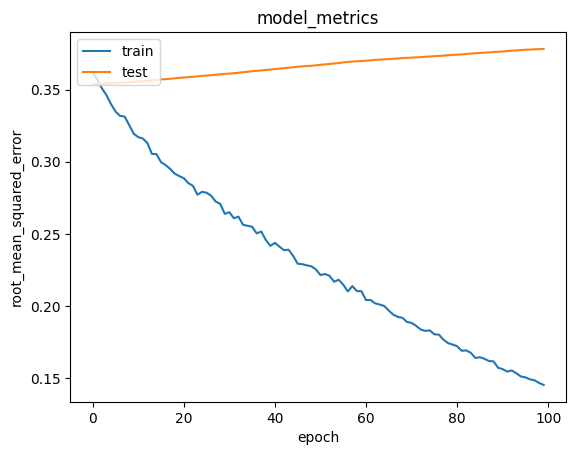

In [92]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan data visual diatas, model yang telah dibuat sebelumnya menghasilkan `root mean squared error` sekitar 0.15 pada data latih dan 0.40 pada data uji.